In [1]:
#NMR superposition 
#Version 1.0.1

######USE NOTES######
# File type must be in CSV format with no titles.
# To obtain this from spinworks:
#    -Export spectrum as txt file, and replace (double space) with comma
#    -Delete the first line of file, so it starts with the first data point
#    -Rename file as "name".csv and choose "all file types"
# Select Ligand Data set first for labeling purposes. 
# Email warej21@up.edu with questions

######Release Notes######
# -1.0.0 - autoscale functionality working. Adjust the buffer to the left or right in "HARD SETTINGS" with var "BUFF"
# -1.0.1 - Auto Labeled Maximums
#        - Added Settings:
#            - Vertical Y axis modifications
#            - Line width
#            - Match Scale of Y axes
#            - Added change arrow option
# -1.0.2 - Added Settings:
#            - Splitting Labels


######TO-DO List######
# - Pull hard settings from .set file -- or -- Add settings GUI (Preffered) 
# - Fix flip-flopped LL/RL dictionaries

In [2]:
import numpy as np
import pandas as pd
from tkinter import Tk
from tkinter.filedialog import askopenfilename
import os
import matplotlib.pyplot as plt

import tkinter

import matplotlib.animation as animation
from matplotlib.backend_bases import key_press_handler
from matplotlib.backends.backend_tkagg import (
    FigureCanvasTkAgg, NavigationToolbar2Tk)
from matplotlib.figure import Figure

In [3]:
###HARD SETTINGS###

#Changes the fraction of the chart to the left & right of peaks
BUFFER = 0.3

#Offsets either the Lig or Coord x axis by vertModFactor
vertModLigandY = False
vertModCoordinatedY = False

vertModFactor = 0.05

#Changes the weight of the plotted lines
lineWidth = 0.5

#Forces the maximum values of both data sets to equal heights
matchYMax = True

#Toggles inter-peak arrow and label
changeArrow = True

#Toggles splitting
splittingLabel = False
#Tolerance is based on % from tallest local peak
splitTolLig = 0.1
splitTolCom = 0.3
#Use overide with peaks that are hidden by noise
splitOverride = False
ovrLig = 5
ovrCom = 5

In [4]:
Tk().withdraw()
#settings=askopenfilename(filetypes=[("Settings Files", "*.py")])
filename1=askopenfilename(filetypes=[("CVS files", "*.csv")])
filename2=askopenfilename(filetypes=[("CVS files", "*.csv")])

In [5]:
DF1=pd.read_csv(filename1)
DF2=pd.read_csv(filename2)

In [6]:
#######

In [7]:
def _getMax(DFin):
    if DFin is DF1:
        DFx, DFy = np.loadtxt(filename1, usecols=[0, 1],
                      unpack=True, delimiter=',')
    else:
        DFx, DFy = np.loadtxt(filename2, usecols=[0, 1],
                      unpack=True, delimiter=',')
    DFmax=DFy.max()
    DFxList=DFx.tolist()
    DFyList=DFy.tolist()
    Index=DFyList.index(DFmax)
    XMax=DFxList[Index]
    return XMax, DFmax, DFx, DFy

In [8]:
def _compareLow(val1,val2):
    if val1>val2:
        return val2
    elif val1<val2:
        return val1
    else:
        return Exception("ERROR: val1 and val2 are exactly equal")

In [9]:
def _compareHigh(val1,val2):
    if val1>val2:
        return val1
    elif val1<val2:
        return val2
    else:
        return Exception("ERROR: val1 and val2 are exactly equal")

In [10]:
def _getScaleFactor():
    global XMaxDF1, XMaxDF2
    diff = abs(XMaxDF1-XMaxDF2)
    scaleFactor = diff*BUFFER
    return scaleFactor

In [11]:
def _getLL():
    global XMaxDF1, XMaxDF2, scaleFactor
    Lmax=_compareLow(XMaxDF1,XMaxDF2)
    LL=Lmax-scaleFactor
    return LL

In [12]:
def _getRL():
    global XMaxDF1, XMaxDF2, scaleFactor
    Rmax=_compareHigh(XMaxDF1,XMaxDF2)
    RL=Rmax+scaleFactor
    return RL

In [13]:
XMaxDF1, YMaxDF1 , DF1x, DF1y=_getMax(DF1)

In [14]:
XMaxDF2, YMaxDF2, DF2x, DF2y=_getMax(DF2)

In [15]:
scaleFactor=_getScaleFactor()

In [ ]:
RL=_getLL()

In [ ]:
LL=_getRL()

In [ ]:
####

In [ ]:
root = tkinter.Tk()
root.wm_title("NMR Overlay")
current_list = ['Ligand', 'Coordinated']

In [ ]:
fig = Figure(figsize=(2, 3), dpi=100)
ax = fig.add_subplot(111)

In [ ]:
#Hard settings variables
vertMod=_compareHigh(YMaxDF1,XMaxDF1)*vertModFactor
scaleMatch= abs(_compareHigh(YMaxDF1,YMaxDF2))/_compareLow(YMaxDF1,YMaxDF2)
XDiff=XMaxDF2-XMaxDF1
MidX = (XMaxDF2+XMaxDF1)/2

In [ ]:
#splitting
def _countSplit(DFin):
    global DF1y, DF2y, YMaxDF1, YMaxDF2, splitTolLig, splitTolCom
    
    if DFin is DF1y:
        DFtemp=DF1y
        DFMaxTemp=YMaxDF1
        splitTol=splitTolLig
    elif DFin is DF2y:
        DFtemp=DF2y
        DFMaxTemp=YMaxDF2
        splitTol=splitTolCom
    else:
        raise Exception("invalid DF, use DF1y or DF2y")
        
    zeroShiftDFtemp=DFtemp-(DFMaxTemp*splitTol)
    zeroLine=DFtemp*0
    zeroCount=((zeroShiftDFtemp[:-1] * zeroShiftDFtemp[1:]) < 0).sum()
    peakCount=zeroCount/2
    print("number of zeroes: "+str(zeroCount))
    print("number of peaks: "+str(peakCount))
    return peakCount, zeroShiftDFtemp, zeroLine

In [ ]:
def _checkOverride():
    
    global splitOverride, ovrLig, ovrComp, splitDF1, splitDF2
    
    if splitOverride is True:
        splitDF1 = ovrLig
        splitDF2 = ovrCom
        ligSplitLet= _splitNumToLet(int(splitDF1))
        comSplitLet= _splitNumToLet(int(splitDF2))
    elif splitOverride is False:
        print("split override is off")
    else:
        raise Exception("splitOverride must be 'True' or 'False'")
        
    return splitDF1, splitDF2

In [ ]:
def _splitNumToLet(splitNum):
    splitLib=["s","d","t","q","quint","m"]
    splitNum -= 1
    if type(splitNum) is not int:
        raise Exception("ERROR: splitting is not a whole number, adjust tolerance or use override")
    elif splitNum <= 5 and splitNum > 0:
        splitLet=splitLib[splitNum]
        return splitLet
    elif splitNum > 5:
        splitNumNew = 5
        splitLetHigh=splitLib[splitNumNew]
        return splitLetHigh
    else:
        raise Exception("ERROR: splitting value is negative or zero")

number of zeroes: 10
number of peaks: 5.0
splitting: quint


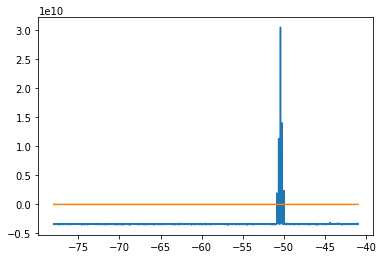

In [ ]:
splitDF1, zeroShiftDF1, zeroLine1=_countSplit(DF1y)
plt.plot(DF1x,zeroShiftDF1)
plt.plot(DF1x,zeroLine1)
ligSplitLet=_splitNumToLet(int(splitDF1))
print("splitting: "+ligSplitLet)

number of zeroes: 6
number of peaks: 3.0
splitting: t


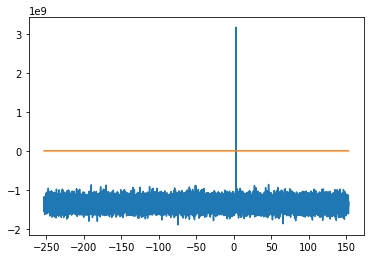

In [ ]:
splitDF2, zeroShiftDF2, zeroLine2=_countSplit(DF2y)
plt.plot(DF2x,zeroShiftDF2)
plt.plot(DF2x,zeroLine2)
comSplitLet=_splitNumToLet(int(splitDF2))
print("splitting: "+comSplitLet)

In [ ]:
splitDF1, splitDF2 = _checkOverride()
print (int(splitDF1), int(splitDF2))
print(ligSplitLet,comSplitLet)


split override is off
5 3
quint t


In [ ]:
for item in current_list:
    if item is "Ligand":
        x1, y1 = np.loadtxt(filename1, usecols=[0, 1],
                      unpack=True, delimiter=',')
        if matchYMax is True and _compareLow(YMaxDF1,YMaxDF2) is YMaxDF1:
            y1 *= scaleMatch
        #invx1= np.flip(x1)
        if vertModLigandY is True:
            ax.plot(x1, y1+vertMod, label="Ligand",linewidth=lineWidth)
        else:
            ax.plot(x1, y1, label="Ligand",linewidth=lineWidth)
    elif item is "Coordinated":
        x2, y2 = np.loadtxt(filename2, usecols=[0, 1],
                      unpack=True, delimiter=',')
        #invx2=np.flip(x2)
        if matchYMax is True and _compareLow(YMaxDF1,YMaxDF2)is YMaxDF2:
            y2 *= scaleMatch
        if vertModCoordinatedY is True:
            ax.plot(x2, y2+vertMod, label="Coordinated",linewidth=lineWidth)
        else:
            ax.plot(x2, y2, label="Coordinated",linewidth=lineWidth)

In [ ]:
fig.legend()

ax.set_xlim(LL,RL)
ax.yaxis.set_visible(False)
ax.set_ylim(0,_compareHigh(YMaxDF1,YMaxDF2)*1.5)

canvas = FigureCanvasTkAgg(fig, master=root)
canvas.draw()
canvas.get_tk_widget().pack(side=tkinter.TOP, fill=tkinter.BOTH, expand=1)

toolbar = NavigationToolbar2Tk(canvas, root)
toolbar.update()
canvas.get_tk_widget().pack(side=tkinter.TOP, fill=tkinter.BOTH, expand=1)

In [ ]:
#annotations
if splittingLabel is True:
    DF1text=str(round(XMaxDF1,3))+"ppm, "+str(ligSplitLet)
    DF2text=str(round(XMaxDF2,3))+"ppm, "+str(comSplitLet)
else:
    DF1text=str(round(XMaxDF1,3))+"ppm"
    DF2text=str(round(XMaxDF2,3))+"ppm"
    
ax.annotate(DF1text, xy=(XMaxDF1, YMaxDF1), xytext=(XMaxDF1, max(y1)+vertMod),ha="center")

ax.annotate(DF2text, xy=(XMaxDF2, YMaxDF2), xytext=(XMaxDF2, max(y2)+vertMod),ha="center")

if changeArrow is True:
    ax.annotate("", xy=(XMaxDF2-5, _compareHigh(YMaxDF2,YMaxDF1)*0.3),
                xytext=(XMaxDF1+5, _compareHigh(YMaxDF2,YMaxDF1)*0.3),
                arrowprops=dict(arrowstyle="->"))
    ax.annotate(str(XDiff)+"ppm", xy=(MidX, _compareHigh(YMaxDF2,YMaxDF1)*0.3+vertMod),
               ha="center")

In [ ]:
def on_key_press(event):
    print("you pressed {}".format(event.key))
    key_press_handler(event, canvas, toolbar)

    canvas.mpl_connect("key_press_event", on_key_press)

In [ ]:
def _quit():
    root.quit()
    root.destroy()

In [ ]:
quitButton = tkinter.Button(master=root, text="Quit", command=_quit)
quitButton.pack(side=tkinter.BOTTOM)

tkinter.mainloop()